## Winter 2022 - Shopify Data Science Intern Challenge 

## Question 1)

Given some sample data, write a program to answer the following:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

    a) Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
    b) What metric would you report for this dataset?
    c) What is its value?

In [109]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [110]:
def get_source_file() -> tuple:
    """
    Returns the file name of the excel / csv source file in the working directory

    @requires: Only 1 excel / csv file source file in the working directory
    @returns: File name of the source excel / csv file and the supported pandas function to read that file type
    """
    files = [f for f in os.listdir('.') if os.path.isfile(f)]
    for f in files:
        if f.split(".")[-1].lower() == "xlsx": return (f, pd.read_excel)
        if f.split(".")[-1].lower() == "csv": return (f, pd.read_csv)
    return "", ""

src_fName, read_data = get_source_file()
# check that file exists
assert len(src_fName) > 0

# now read in data
shop_df = read_data(src_fName)

Now familiarize myself with the source data and print basic statistics.

In [111]:
shop_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773


In [112]:
target_col_name = "order_amount" # so i don't have to change name everywhere if source changes
shop_df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


Right away from the .describe method output above I can tell few things:

- $3145 AOV is the mean of all of the 5000 data entries of order_amount column
- The maximum value of order_amount is $704,000. This is either an invalid entry, business purchase, or someone really likes their sneakers.
- Looking at order_amount and total_items together, it's obvious that a best representation of the average order_amount will be for a "normal" amount of shoes. 2000 shoes order is an exception not a standard.

Let's explore those higher orders a bit more

In [113]:
shop_df[shop_df[target_col_name].isin(np.sort(shop_df[target_col_name].unique())[-1:-2:-1])].sort_values(by="created_at")

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00


So user 607 is the one that purchases 2000 items at 4PM multiple times a month. Some days they make 2 orders at the exactly same time which should probably trigger some sort of fraud check unless this is an automated process by another company. It's also weird that order_id is lower for later dates than earlier dates. It depends on the database implementation but still an interesting observation.

Now that we know that there are a few large orders, let's instead of the median look at at the median, 25%, and 75% quantiles.

In [114]:
target_col = shop_df[target_col_name]
print(f"Median is: {target_col.median()}")
print(f"25th quantile is: {target_col.quantile(0.25)}")
print(f"75th quantile is: {target_col.quantile(0.75)}")

Median is: 284.0
25th quantile is: 163.0
75th quantile is: 390.0


We can clean up data and show a boxplot of the source data without the outliers. To do this we can use IQR (Interquartile range box plot) rule. That is 

IQR = Q3 (75%) - Q1 (25%)

and only data within Q1 - 1.5*IQR and Q3 + 1.5*IQR is not an outlier.

Filtered median is: 280.0
Filtered 25th quantile is: 162.0
Filtered 75th quantile is: 380.0


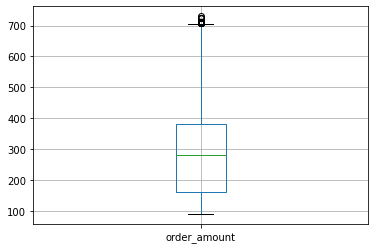

In [115]:
Q1 = target_col.quantile(0.25)
Q3 = target_col.quantile(0.75)
IQR = Q3 - Q1

filtered_df = shop_df[(shop_df[target_col_name] >= Q1 - IQR*1.5) & (shop_df[target_col_name] <= Q3 + IQR*1.5)]
filtered_df.boxplot(column=target_col_name)
print(f"Filtered median is: {filtered_df[target_col_name].median()}")
print(f"Filtered 25th quantile is: {filtered_df[target_col_name].quantile(0.25)}")
print(f"Filtered 75th quantile is: {filtered_df[target_col_name].quantile(0.75)}")

### Answer to Question 1:

    a) The original calculation used mean of the order value. Because the order value contained large outliers, the mean was very high. There are points to be made regarding those outliers such as asking if the data is valid or not, but for the purposes of this task I assumed all data is valid.
    b) A good metric to report depends on the information reader wants to know. Someone on the business team may actually want to know the order value per shoe pair rather than total order value. This is because they may care more about margin per shoe sold than total amount sold. However, without knowing the business context, I would report the median order value of the source database since it is about the same as the median of the filtered database without outliers.
    c) It's value is $284.0

## Question 2)
For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

    a) How many orders were shipped by Speedy Express in total?
    b) What is the last name of the employee with the most orders?
    c) What product was ordered the most by customers in Germany?


a) Answer = 54

SELECT COUNT(*) \
FROM (Shippers \
INNER JOIN Orders ON Shippers.ShipperID = Orders.ShipperID) \
WHERE Shippers.ShipperName = "Speedy Express" 


b) Answer = Peacock - 40 orders

SELECT TOP 1 * FROM( \
SELECT emp.LastName, COUNT( * ) AS EmpCount \
FROM (Employees emp \
INNER JOIN Orders ord ON emp.EmployeeID = ord.EmployeeID) \
GROUP BY emp.LastName \
ORDER BY COUNT(*) DESC) \

Note that I had to use TOP 1 because LIMIT does not work in Firefox.

c) Answer = Boston Crab Meat - 160 units ordered


SELECT Customers.Country, \
       Products.ProductName, \
       SUM(OrderDetails.Quantity) as ValCount \
FROM   Customers \
       INNER JOIN Orders \
         ON Customers.CustomerID = Orders.CustomerID \ 
       INNER JOIN OrderDetails \
         ON Orders.OrderID = OrderDetails.OrderID \ 
       INNER JOIN Products \
         ON OrderDetails.ProductID = Products.ProductID \
WHERE Customers.Country = "Germany" \
GROUP BY Products.ProductName \
ORDER BY ValCount DESC \
LIMIT 1 \

For this question I used Chrome instead of Firefox.